## Coletando dados
##### Coletando dados salvos estaticamente na pasta `./data`

In [45]:
import pandas as pd

df = pd.read_csv("./data/data.csv",low_memory=False)


## Convertendo valor de renda per capita para numérico
##### Extraindo os valores de `Renda Per Capita`, transformando de categorico para numerico, atraves da media entre o menor e o maior valor. 

In [46]:
import re 
import numpy as np

def convert_renda_per_capita(value):
    if isinstance(value, str):
        match = re.match(r"(\d+,\d+|\d+) Sm < Rfp <= (\d+,\d+|\d+) Sm", value)
        if match:
            lower_bound = float(match.group(1).replace(",", "."))
            upper_bound = float(match.group(2).replace(",", "."))
            return (lower_bound + upper_bound) / 2
    return np.nan

df["Renda per Capita"] = df["Renda per Capita"].apply(convert_renda_per_capita)

## Pré-processando valores nulos 
##### Processando valores nulos, para valores categoricos atribuir categoria `Desconhecido`, para variaveis numericas, tirando `Renda Per Capita`, atribuimos a media dos valores daquela coluna. Para fins de desenvolvimento, salvamos os dados processados na pasta `./data/processed_data.csv`


In [47]:
def pre_process(df) -> pd.DataFrame:
    df = df.copy()
    for coluna in df.columns:
        if df[coluna].dtype in ["float64", "int64"]:  
            if coluna == "Renda per Capita":
                df = df[df["Renda per Capita"].notnull() & (df["Renda per Capita"] != "")]
            df[coluna] = df[coluna].fillna(df[coluna].mean())  
        elif df[coluna].dtype == "object":
                df[coluna] = df[coluna].apply(
                    lambda x: "Desconhecido" if coluna != "Sexo" and (pd.isna(x) or len(str(x)) < 3) else x
                )
    return df

df = pre_process(df)
df.to_csv('./data/processed_data.csv', index=False)

## Tratando outliers
##### Através do modelo `isolation-florest`, conseguimos extrair os padrões dos dados do nosso dataset, e através desse padrao conseguimos dizer se um certo valor está dentro do padrão ou não, atribuindo um score que é analisado pelo modelo, e de acordo com a contaminação estabelecida e o padrão dos demais scores, deleta ou mantem o valor em questão. Para fins de desenvolvimento, salvamos os dados tratados na pasta `./data/cleaned_data.csv`

In [48]:
from sklearn.ensemble import IsolationForest

def remove_outliers(df):
    isolation_forest = IsolationForest(contamination=0.05)  

    numeric_columns = df.select_dtypes(include=[np.number]).columns
    df_numeric = df[numeric_columns]
    
    outliers = isolation_forest.fit_predict(df_numeric)

    df_cleaned = df[outliers == 1]
    
    return df_cleaned

df = remove_outliers(df)
df.to_csv('./data/cleaned_data.csv',index=False)

## Definindo features e o target
##### Definindo de forma estatica as colunas que serão as features usadas nos modelos de regressão, bem como a coluna alvo.

In [49]:
categorical_columns = [
        "Modalidade do Curso", 
        "Tipo do Curso",
        "Sexo",
        "Etnia",
        "Área do Curso",
]
numeric_columns = [
        "Idade de Entrada",
        "Periodo de Ingresso",
]

target_column = "Renda per Capita"

## Análise exploratória
##### Nessa etapa, fazemos uma análise explóratoria dos nossos dados, tentando entender e analisar graficamente a correlacao entre as features e a coluna alvo, e bem como se comportam.

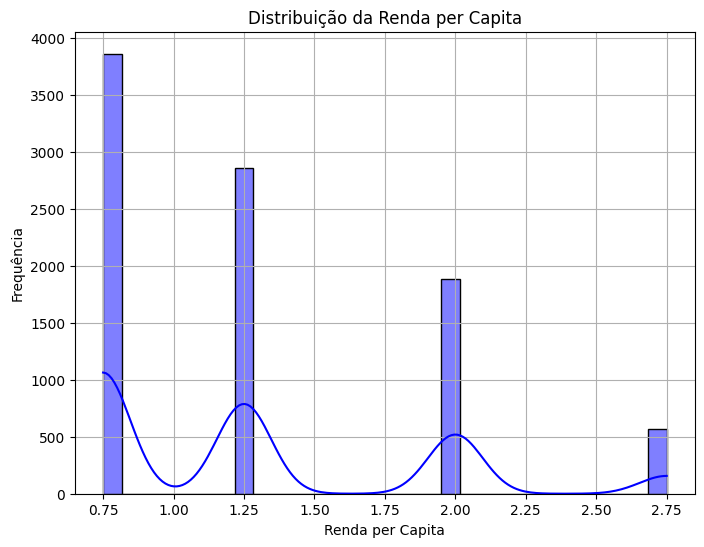

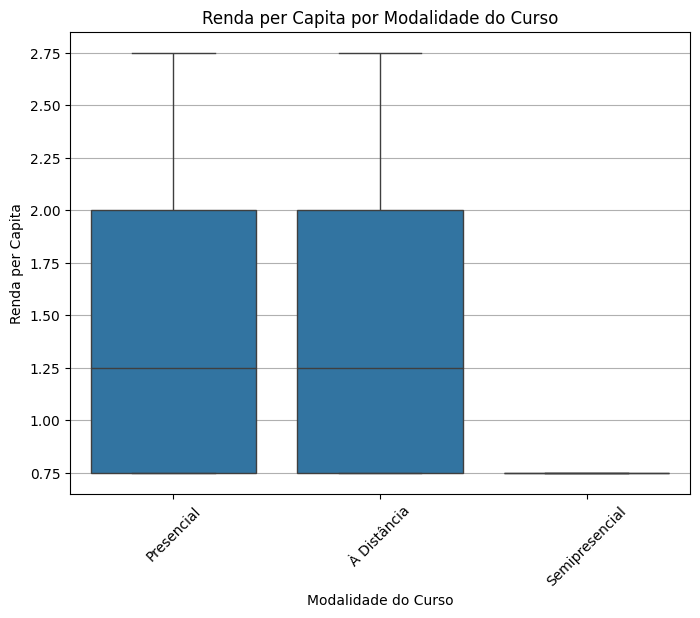

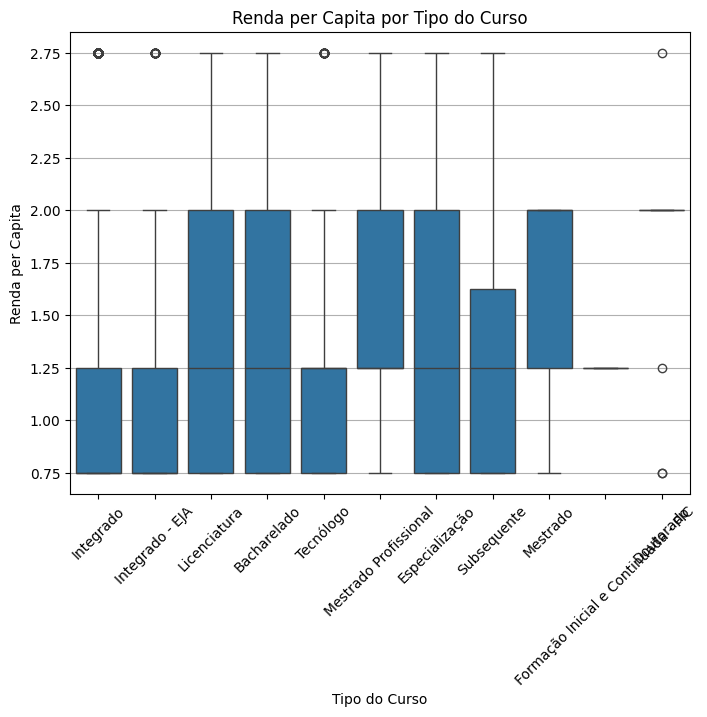

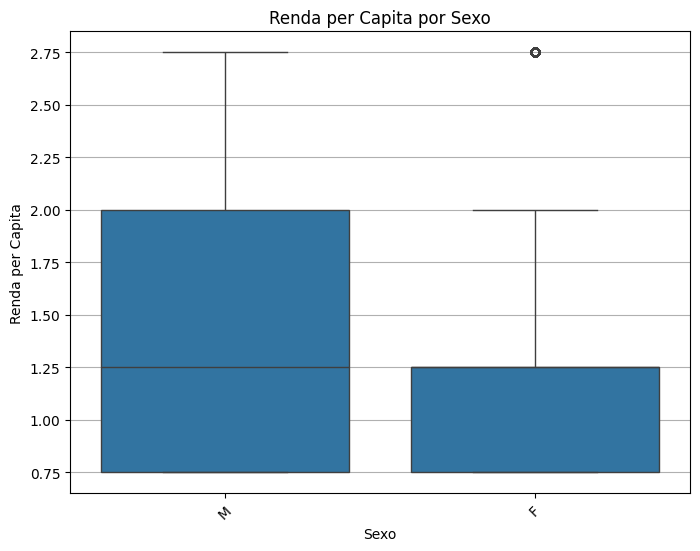

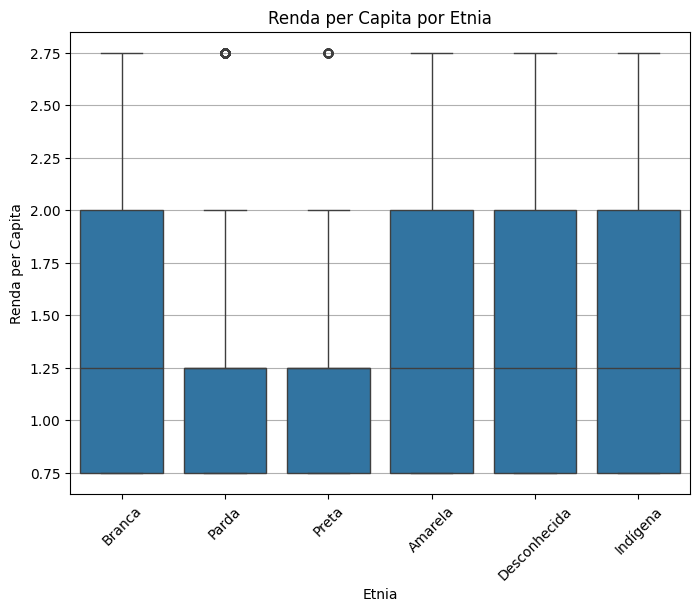

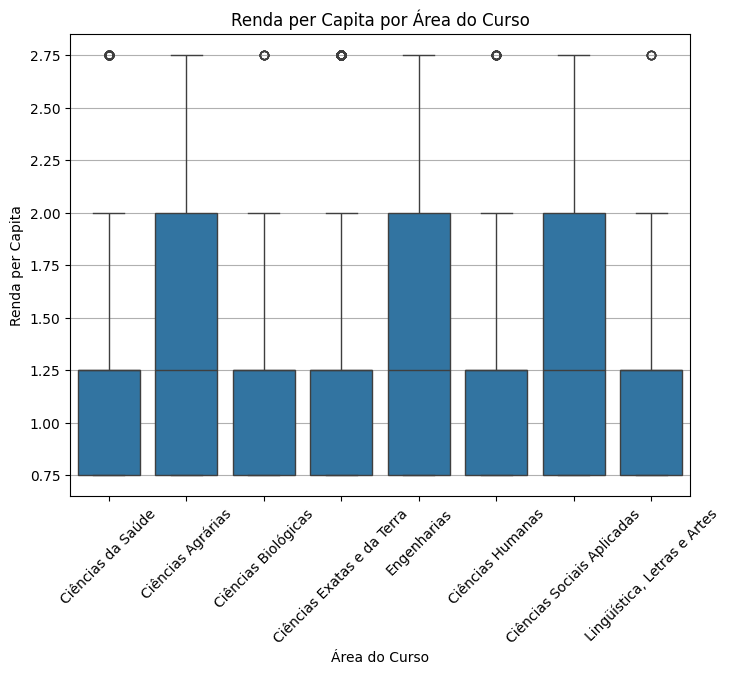

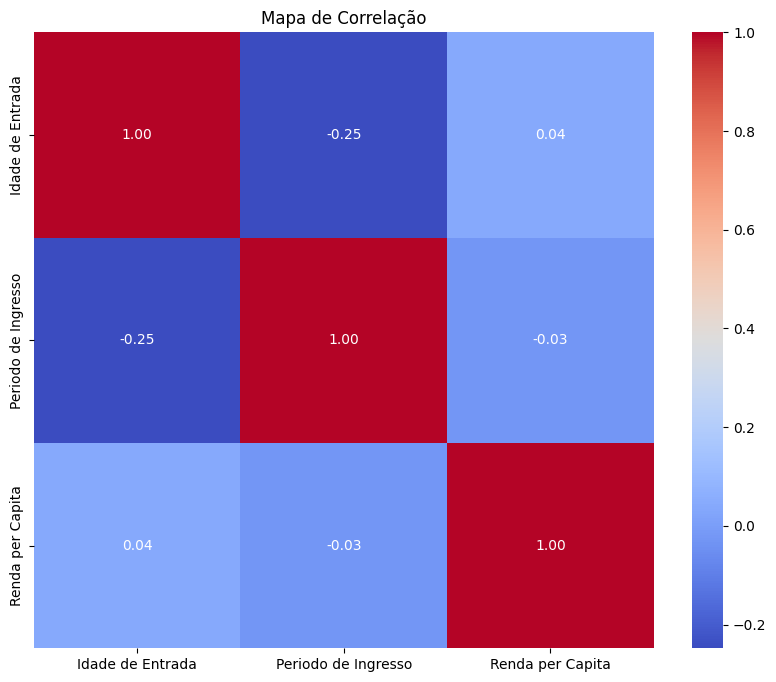

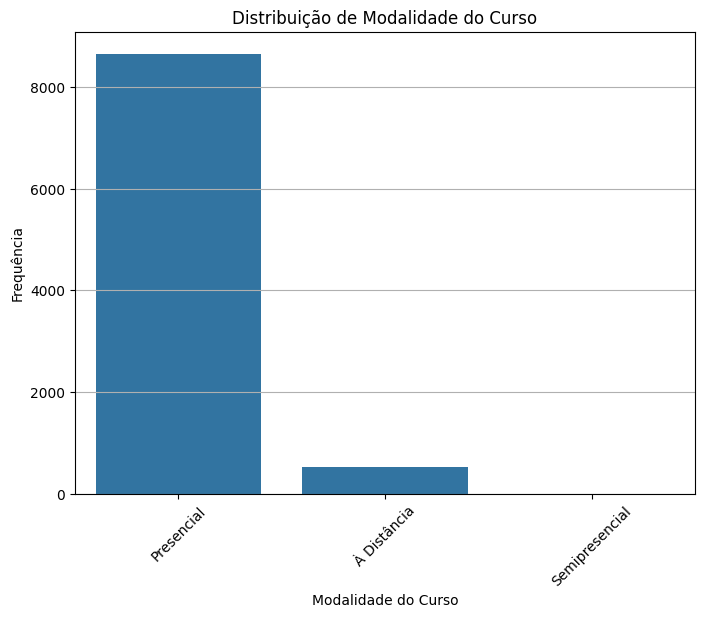

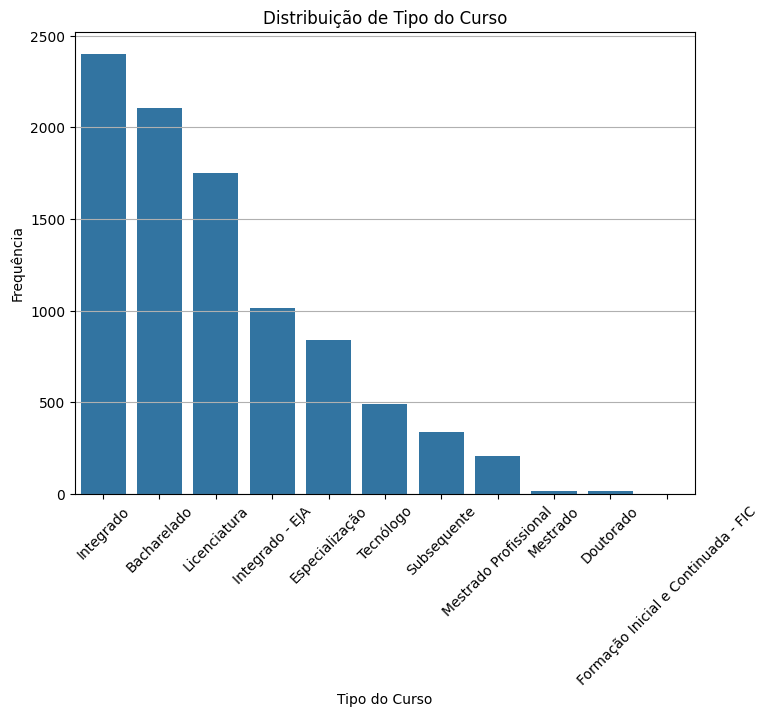

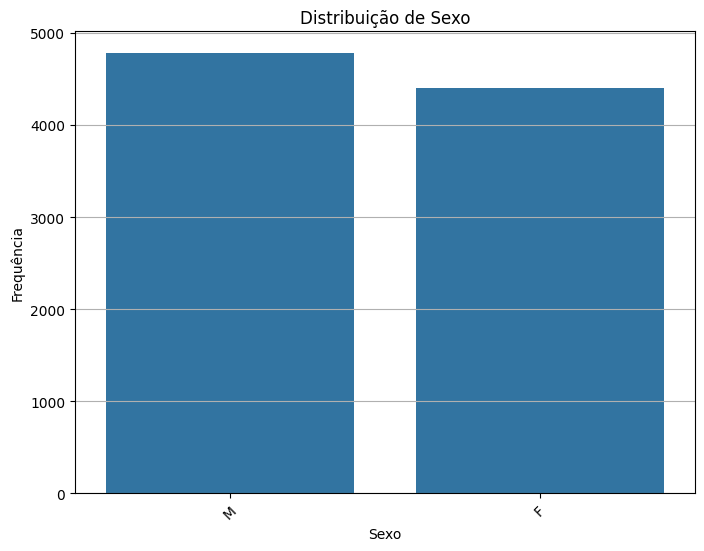

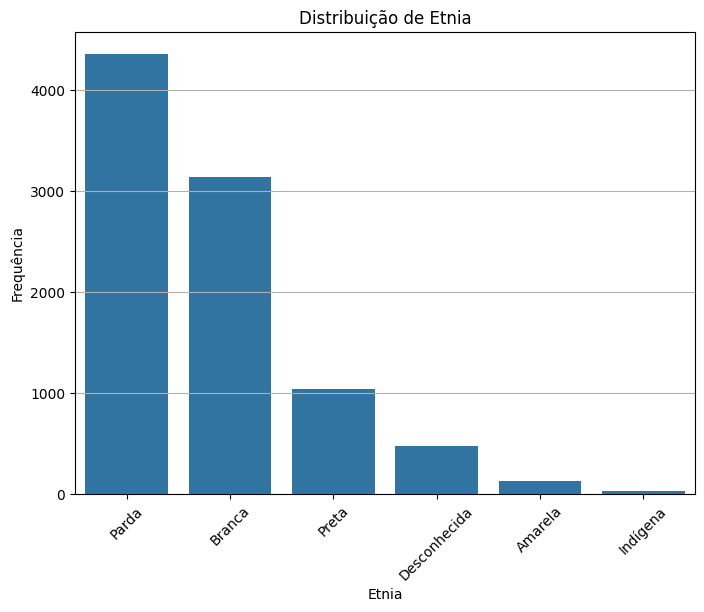

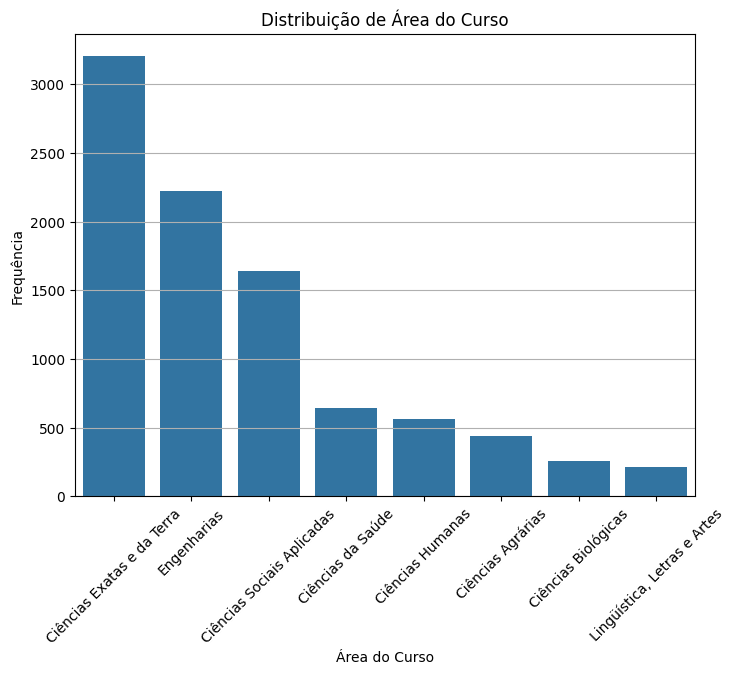

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns

# Renda per Capita 
plt.figure(figsize=(8, 6))
sns.histplot(df[target_column], kde=True, bins=30, color="blue")
plt.title("Distribuição da Renda per Capita")
plt.xlabel("Renda per Capita")
plt.ylabel("Frequência")
plt.grid()
plt.show()

# Categorical Columns
for col in categorical_columns:
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=df, x=col, y=target_column)
    plt.title(f"Renda per Capita por {col}")
    plt.xlabel(col)
    plt.ylabel("Renda per Capita")
    plt.xticks(rotation=45)
    plt.grid(axis="y")
    plt.show()


# Correlation
correlation_matrix = df[numeric_columns + [target_column]].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Mapa de Correlação")
plt.show()

# Distribuition
for col in categorical_columns:
    plt.figure(figsize=(8, 6))
    sns.countplot(data=df, x=col, order=df[col].value_counts().index)
    plt.title(f"Distribuição de {col}")
    plt.xlabel(col)
    plt.ylabel("Frequência")
    plt.xticks(rotation=45)
    plt.grid(axis="y")
    plt.show()


## Transformando os dados
##### Nessa etapa, fazemos uma mistura de técnicas de transformação de dados, como `one-hot-encoding` para transformar as variaveis categoricas em variaveis numéricas.

In [51]:
from sklearn.preprocessing import OneHotEncoder,StandardScaler

def transform_data(df: pd.DataFrame) -> pd.DataFrame:
    X_categorical = df[categorical_columns]
    X_numeric = df[numeric_columns]
    y = df[[target_column]] 
    
    encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
    X_encoded = encoder.fit_transform(X_categorical)
    X_encoded_df = pd.DataFrame(X_encoded, columns=encoder.get_feature_names_out(categorical_columns), index=df.index)
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_numeric)
    X_scaled_df = pd.DataFrame(X_scaled, columns=numeric_columns, index=df.index)
    
    
    df_encoded = pd.concat([X_encoded_df, X_scaled_df, y], axis=1)

    
    return df_encoded


df = transform_data(df)
df.to_csv('./data/encoded_data.csv',index=False)



## Separando dataset
##### Nessa etapa, estamos separando os nossos dados, divindo entre treino e teste. Nesse caso foi utilizado 70% dos dados para treino e 30% para teste. A biblioteca utilizada foi `sklearn.model_selection` com a funcao `train_test_split`

In [52]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=[target_column])  
y = df[target_column]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Treinamento com modelos de regressão
##### Essa etapa consiste em fazer o split do nosso dataset, em dados de treino e de teste, e realizar o treinamento dos nossos dados com o modelo de `linear-regression` e `decision-tree-regression`, ambos da biblioteca `sklearn`

In [53]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

y_pred_linear = linear_model.predict(X_test)

tree_model = DecisionTreeRegressor(random_state=42)
tree_model.fit(X_train, y_train)

y_pred_tree = tree_model.predict(X_test)


## Aplicando testes
##### Nessa etapa, iremos aplicar os testes, e ver como os nossos dados se comportaram diante os dois modelos utilizados, e analisar caracteristicas como viés e variância dos nossos dados, bem como o resultado dos nossos modelos de regressão

In [ ]:
from sklearn.metrics import mean_squared_error
from mlxtend.evaluate import bias_variance_decomp
import numpy as np

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_linear_test = rmse(y_test, y_pred_linear)
rmse_linear_train = rmse(y_train, linear_model.predict(X_train))

rmse_tree_test = rmse(y_test, y_pred_tree)
rmse_tree_train = rmse(y_train, tree_model.predict(X_train))

print(f"Linear Regression - Training RMSE: {rmse_linear_train}")
print(f"Linear Regression - Test RMSE: {rmse_linear_test}")
print(f"Decision Tree - Training RMSE: {rmse_tree_train}")
print(f"Decision Tree - Test RMSE: {rmse_tree_test}")

linear_error, linear_bias, linear_variance = bias_variance_decomp(
    linear_model, 
    X_train.to_numpy(), 
    y_train.to_numpy(), 
    X_test.to_numpy(), 
    y_test.to_numpy(), 
    random_seed=123, 
    loss='mse'
)

tree_error, tree_bias, tree_variance = bias_variance_decomp(
    tree_model, 
    X_train.to_numpy(), 
    y_train.to_numpy(),     
    X_test.to_numpy(), 
    y_test.to_numpy(), 
    random_seed=123, 
    loss='mse'
)
print(f"Linear Regression - Bias: {linear_bias}")
print(f"Linear Regression - Variance: {linear_variance}")
print(f"Linear Regression - Error: {linear_error}")

print(f"Decision Tree - Bias: {tree_bias}")
print(f"Decision Tree - Variance: {tree_variance}")
print(f"Decision Tree - Error: {tree_error}")


Linear Regression - Training RMSE: 0.5822787139464342
Linear Regression - Test RMSE: 0.5942603496391975
Decision Tree - Training RMSE: 0.4522444001037517
Decision Tree - Test RMSE: 0.6981377446361456
Linear Regression - Bias: 0.3531245155791135
Linear Regression - Variance: 0.001346433005606361
Linear Regression - Error: 0.35447094858471984
Decision Tree - Bias: 0.4078284650971536
Decision Tree - Variance: 0.11239560241802071
Decision Tree - Error: 0.5202240675151742


## Plotando gráficos para visualização
##### Nessa etapa, iremos pegar os dados dos testes, e plotando, com fim de analisar de forma mais visual o que foi extraido.

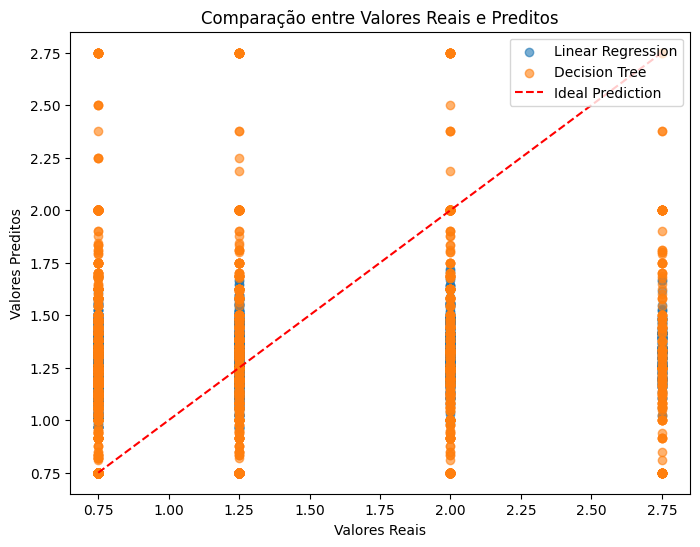

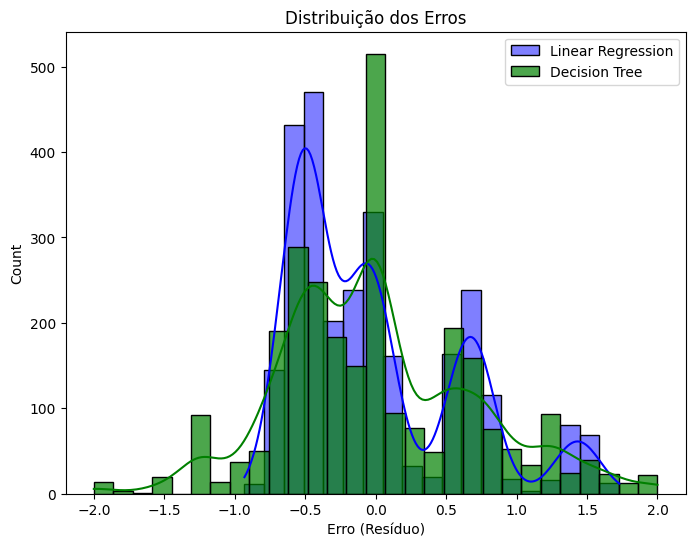

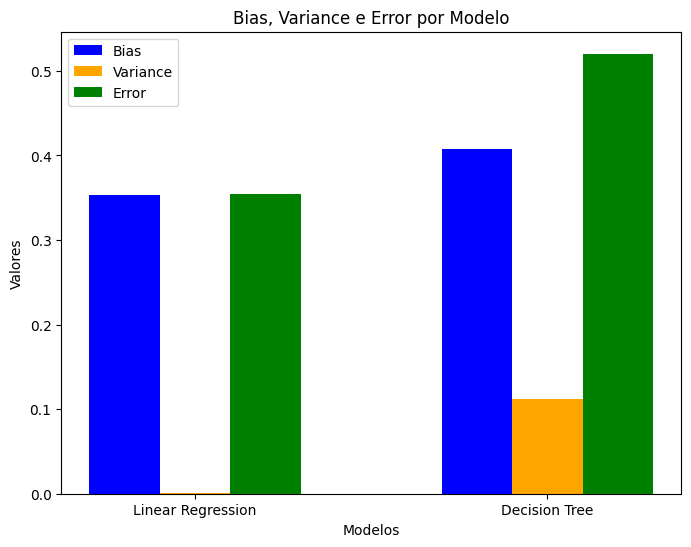

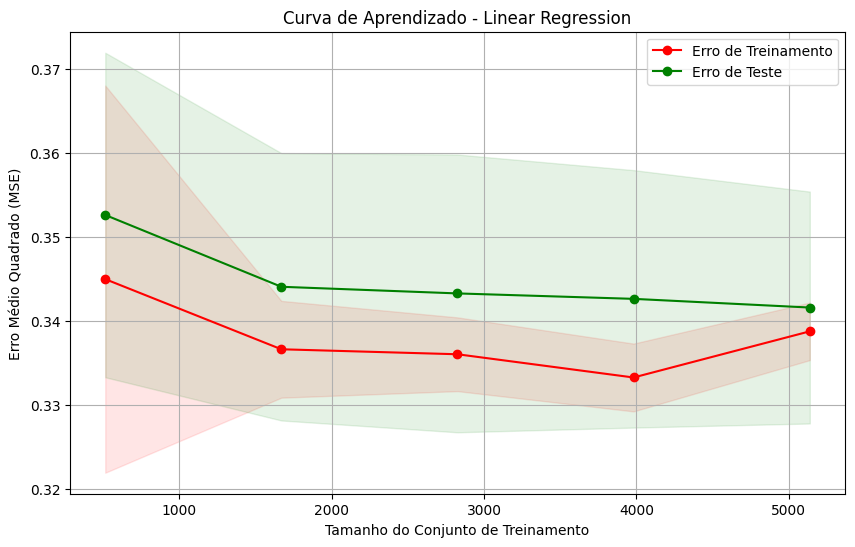

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import learning_curve

# Gráfico de Erro de Predição
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_linear, alpha=0.6, label="Linear Regression")
plt.scatter(y_test, y_pred_tree, alpha=0.6, label="Decision Tree")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color="red", linestyle="--", label="Ideal Prediction")
plt.xlabel("Valores Reais")
plt.ylabel("Valores Preditos")
plt.title("Comparação entre Valores Reais e Preditos")
plt.legend()
plt.show()


# Gráfico de Distribuição dos Erros
residuals_linear = y_test - y_pred_linear
residuals_tree = y_test - y_pred_tree

plt.figure(figsize=(8, 6))
sns.histplot(residuals_linear, kde=True, color="blue", label="Linear Regression")
sns.histplot(residuals_tree, kde=True, color="green", label="Decision Tree", alpha=0.7)
plt.xlabel("Erro (Resíduo)")
plt.title("Distribuição dos Erros")
plt.legend()
plt.show()


# Gráfico de Viés e Variância
models = ["Linear Regression", "Decision Tree"]
bias = [linear_bias, tree_bias]
variance = [linear_variance, tree_variance]
error = [linear_error, tree_error]

x = range(len(models))
width = 0.2

plt.figure(figsize=(8, 6))
plt.bar(x, bias, width=width, label="Bias", color="blue")
plt.bar([p + width for p in x], variance, width=width, label="Variance", color="orange")
plt.bar([p + width * 2 for p in x], error, width=width, label="Error", color="green")

plt.xlabel("Modelos")
plt.ylabel("Valores")
plt.title("Bias, Variance e Error por Modelo")
plt.xticks([p + width for p in x], models)
plt.legend()
plt.show()


# Learning Curve (Curva de Aprendizado)
train_sizes, train_scores, test_scores = learning_curve(
    linear_model, X_train, y_train, cv=5, scoring="neg_mean_squared_error", n_jobs=-1
)

train_scores_mean = -np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.title("Curva de Aprendizado - Linear Regression")
plt.xlabel("Tamanho do Conjunto de Treinamento")
plt.ylabel("Erro Médio Quadrado (MSE)")
plt.grid()

plt.fill_between(
    train_sizes,
    train_scores_mean - train_scores_std,
    train_scores_mean + train_scores_std,
    alpha=0.1,
    color="r",
)
plt.fill_between(
    train_sizes,
    test_scores_mean - test_scores_std,
    test_scores_mean + test_scores_std,
    alpha=0.1,
    color="g",
)

plt.plot(train_sizes, train_scores_mean, "o-", color="r", label="Erro de Treinamento")
plt.plot(train_sizes, test_scores_mean, "o-", color="g", label="Erro de Teste")

plt.legend(loc="best")
plt.show()


